Project chapters:

1. Data Engineering  DONE!<br />
    a) data discovery DONE! <br />
    b) data cleanup DONE!
    
2. Data Analysis <br />
    a) data distributions <br />
    b) data correlations <br />
    c) business relevant summary <br />
3. Data Science <br />
    a) Bike usage predictive model <br />
    b) feature engineering <br />
  

IDEAS <br />
* build a LR model (or other model) to predict the Rented Bike Count <br />
* predict visibility based on other weather features<br />
* check rent bike distribution per day (histogram)<br />
* Hypothesis testing: Spring time has higher mean bike rent count<br />
* analyze rented bike count fluctuations across the year<br />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 40em; }</style>"))

C:\Users\Rogo\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Engineering

## Data discovery

In [2]:
#inspecting column names and data types;
bikes_df = pd.read_csv('SeoulBikeData.csv')
print(bikes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

In [3]:
#showing first 5 rows of data
bikes_df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


There are no missing values in any of the columns. Some Object data types can be adjusted for easier handling, e.g. "Date" changed into a Datetime object, "Holiday" and "Functioning Day" changed into Boolean after confirming they hold two unique values.

In [4]:
bikes_df['Holiday'].unique()

array(['No Holiday', 'Holiday'], dtype=object)

In [5]:
bikes_df['Functioning Day'].unique()

array(['Yes', 'No'], dtype=object)

In [6]:
#summary of the dataset
bikes_df.describe()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [7]:
bikes_df.Date.loc[0]

'01/12/2017'

In [8]:
bikes_df.Date.loc[len(bikes_df)-1]

'30/11/2018'

The dataset includes rented bike counts from Dec 1st. 2017 to Nov. 30th 2018. The data is provided for every hour of the day, along with weather information including Temperature, Humidity, Wind Speed and Rainfall. It also describes the Season of the year for every entry and indicates whether it was a holiday or not. The bike renting service was not always available, which is described by the Functioning Day column.

The dataset consists of 8760 entries in total. The mean bike count rent is 705 rents per hour, while the median amounts to 505 rents. This difference is most likely linked to outliers with unusually high counts of bike rents. This is further reinforced by checking the min/max values for the rented bike count, which are 0 and 3556 respectively - the latter number being an example of the outlier.

The average year temperature amounts to 12.9 degrees Celsius with a median of 13.7.

An interesting observation can be made with Rainfall and Snowfall features - while they have a relatively low mean values (1.1 mm and 0.4 mm respectively), their median values are both at 0. This essentially means that over 50% of days there were no rain- or snowfalls. With that in mind, it stands to question whether these features shouldn't be boolean and signify whether it was raining or not during the given hour of a day. This might simplify any models built within this exercise without affecting their accuracy.

## Data Cleanup

Since both Holiday and Functioning Day features include only 2 unique values each, turning their data type into boolean will make further data processing more efficient. The Date feature will be turned a proper Datetime type along the way.

In [9]:
#changing Date feature into Datetime
bikes_df['Date'] = pd.to_datetime(bikes_df['Date'], format="%d/%m/%Y")

#changing Holiday feature into Boolean
bikes_df.loc[bikes_df['Holiday'] == 'Holiday', 'Holiday'] = 1
bikes_df.loc[bikes_df['Holiday'] == 'No Holiday', 'Holiday'] = 0
bikes_df['Holiday'] = bikes_df['Holiday'].astype(bool, copy=False)

#changing Functioning Day feature into Boolean
bikes_df.loc[bikes_df['Functioning Day'] == 'No', 'Functioning Day'] = 0
bikes_df.loc[bikes_df['Functioning Day'] == 'Yes', 'Functioning Day'] = 1
bikes_df['Functioning Day'] = bikes_df['Functioning Day'].astype(bool, copy=False)

#checking the data types after changes
print(bikes_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      8760 non-null   datetime64[ns]
 1   Rented Bike Count         8760 non-null   int64         
 2   Hour                      8760 non-null   int64         
 3   Temperature(C)            8760 non-null   float64       
 4   Humidity(%)               8760 non-null   int64         
 5   Wind speed (m/s)          8760 non-null   float64       
 6   Visibility (10m)          8760 non-null   int64         
 7   Dew point temperature(C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)   8760 non-null   float64       
 9   Rainfall(mm)              8760 non-null   float64       
 10  Snowfall (cm)             8760 non-null   float64       
 11  Seasons                   8760 non-null   object        
 12  Holiday             

# Data Analysis

## Data distributions

In [10]:
grouping = bikes_df.groupby('Holiday').size().reset_index()
grouping.columns= ['Feature', 'Count']
print(grouping)

   Feature  Count
0    False   8328
1     True    432


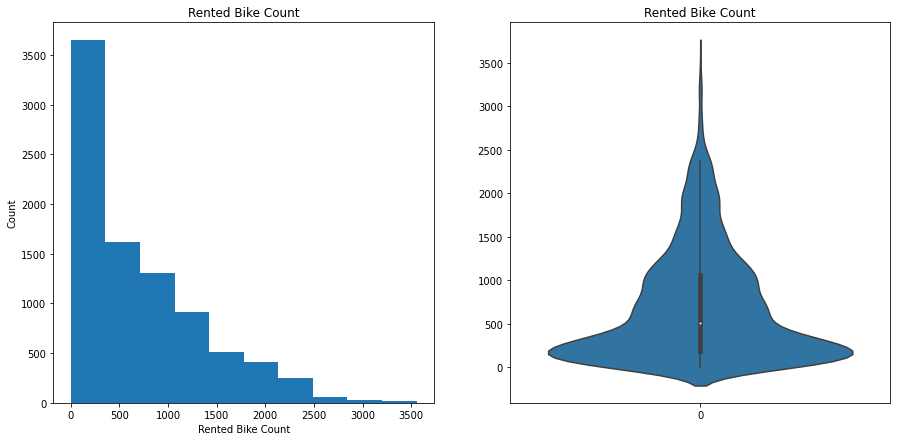

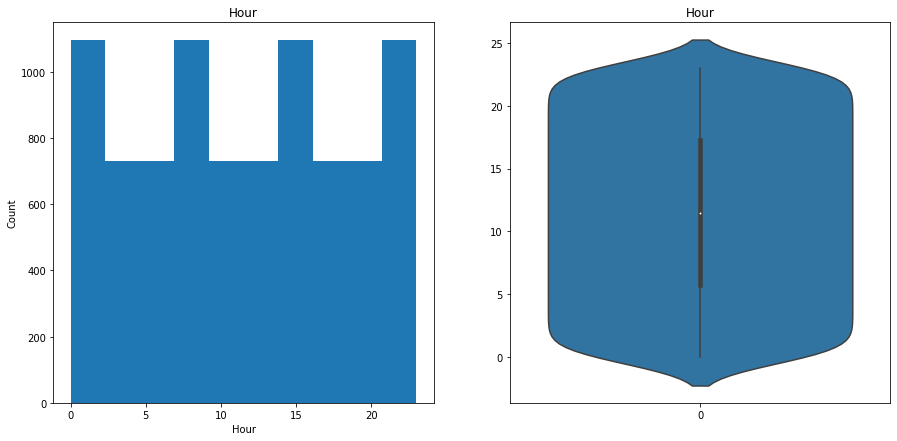

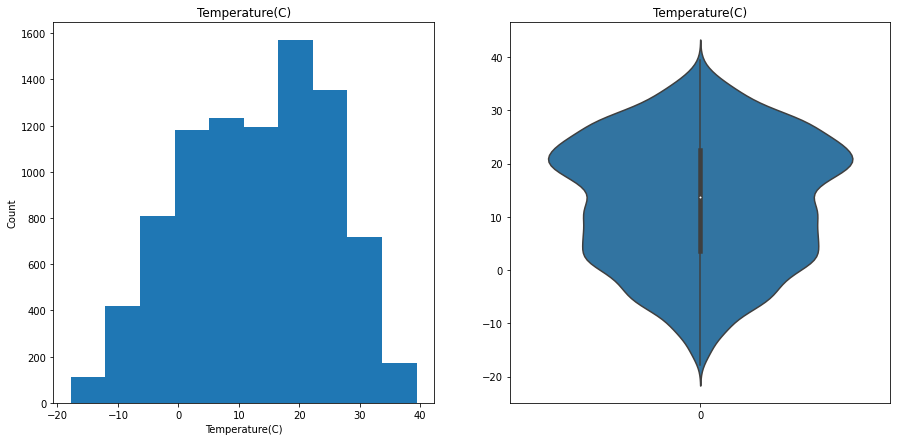

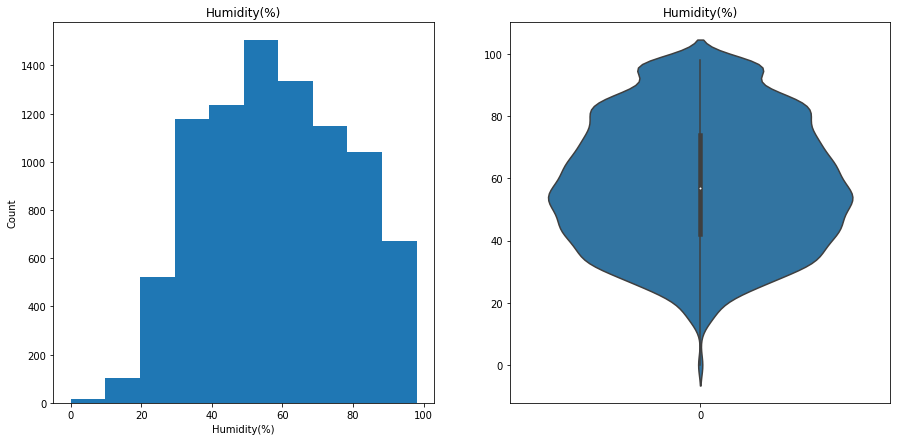

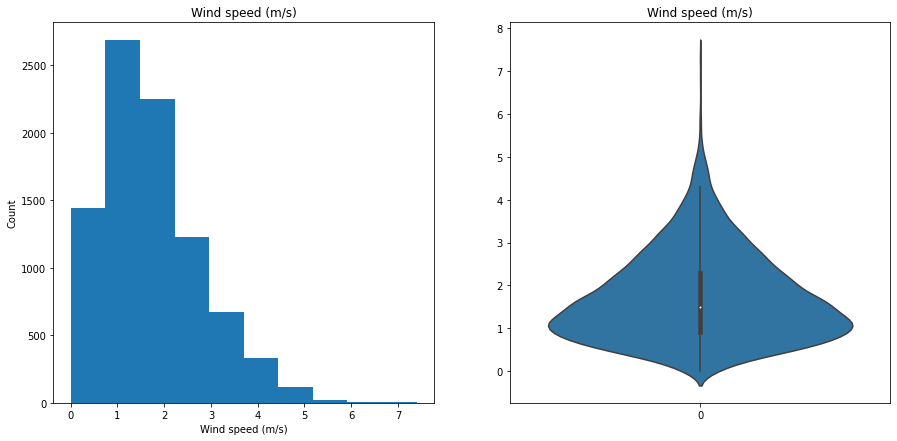

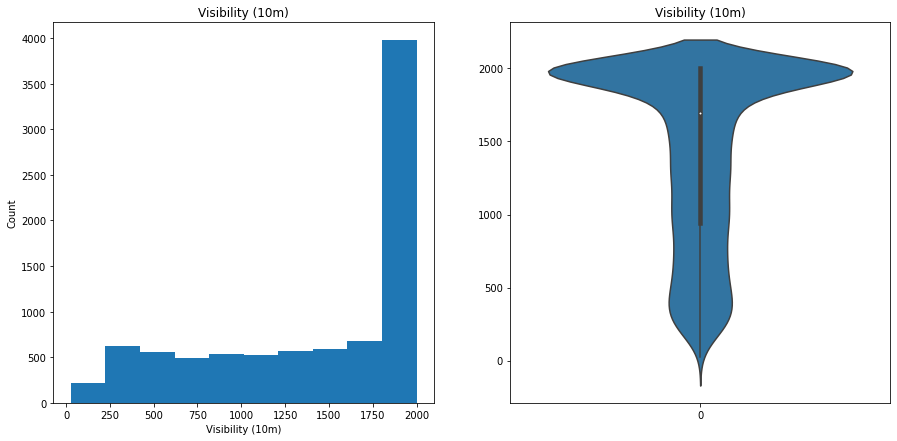

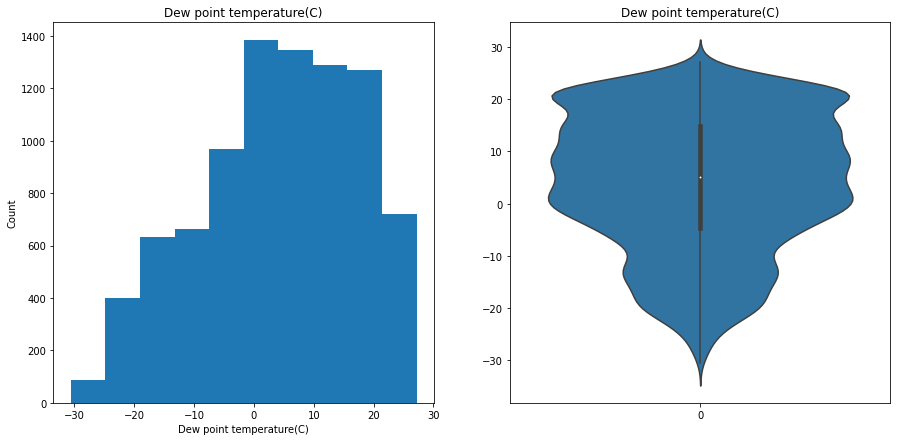

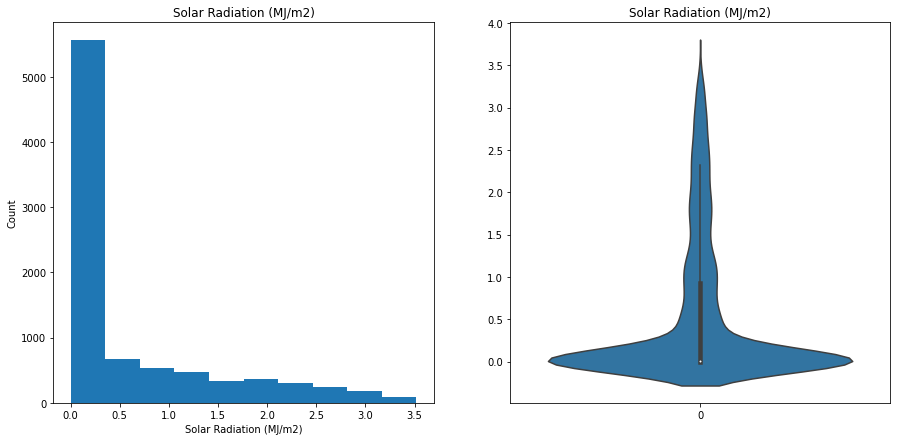

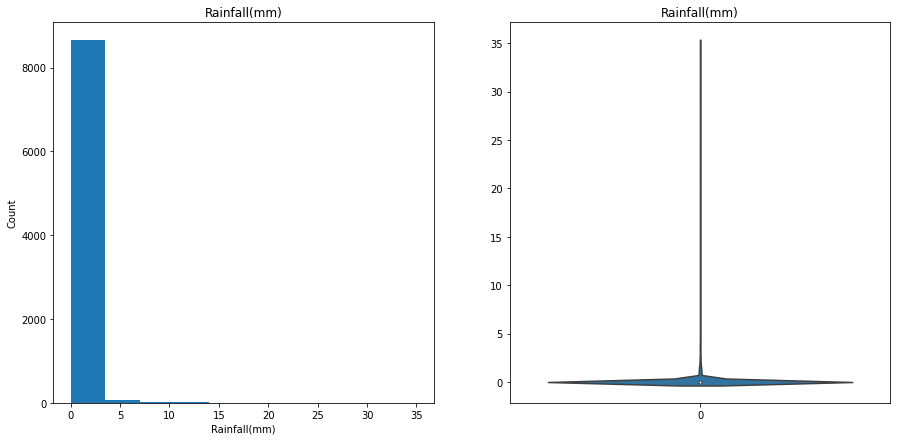

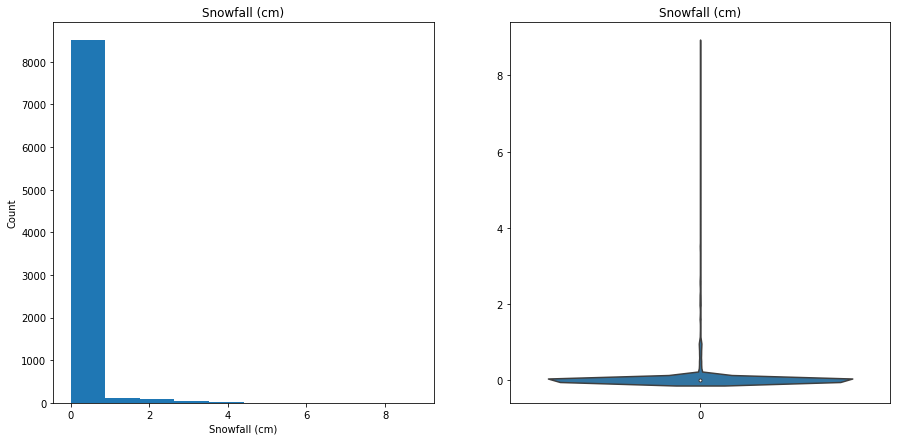

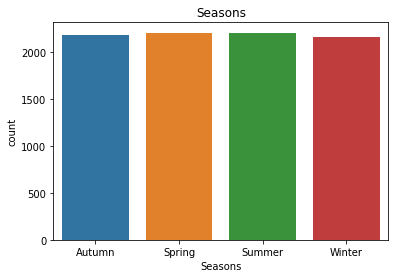

In [22]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; }</style>"))

for i in bikes_df.columns:
    if i == 'Date' or bikes_df[i].dtype == 'bool':
        continue
    elif bikes_df[i].dtype == 'object':
        grouping = bikes_df.groupby(i).size().reset_index()
        grouping.columns = [i, 'count']
        sns.barplot(data = grouping,  x = i, y = 'count')
        plt.title(i)
        plt.show()
        plt.clf
    else:
        fig, ax = plt.subplots(figsize=(15,7))
        ax = plt.subplot(1,2,1)
        plt.figure
        plt.hist(bikes_df[i])
        plt.title(i)
        plt.xlabel(i)
        plt.ylabel('Count')
        ax = plt.subplot(1,2,2)
        sns.violinplot(data=bikes_df[i])
        plt.title(i)
        plt.show()
        plt.clf

Visibility is heavily skewed (do the violin plot for median check)
Temp and Humidity are normally distributed
Wind speed slightly right skewed
Dew point temperature slightly left skewed
Solar radiation, small variance, do the violin plot
Rainfall and snowfall - do more bins, handle outliers
Season - will be correlated with other features

In [12]:
print(bikes_df.shape)
print(len(bikes_df[bikes_df['Functioning Day'] == False]))


(8760, 14)
295


analyze rented bike count fluctuations across the year

In [47]:

bikes_df['Month'] = pd.DatetimeIndex(bikes_df['Date']).month


0       12
1       12
2       12
3       12
4       12
        ..
8755    11
8756    11
8757    11
8758    11
8759    11
Name: Month, Length: 8760, dtype: int64

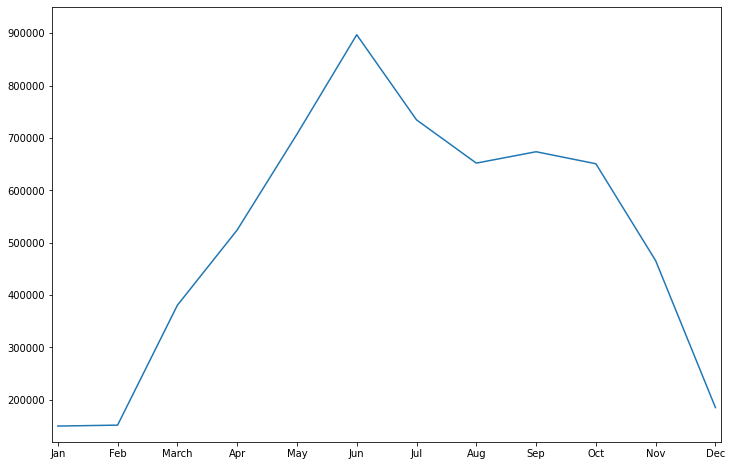

In [76]:
from matplotlib.axes import Axes
rent_month_group = bikes_df[['Month','Rented Bike Count']].groupby(['Month']).sum().reset_index()
plt.figure(figsize=(12,8))
plt.plot(rent_month_group['Month'], rent_month_group['Rented Bike Count'])
plt.axis([0.9,12.1, 120000, 950000])
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], labels=['Jan', 'Feb', 'March','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## DATA CORRELATIONS

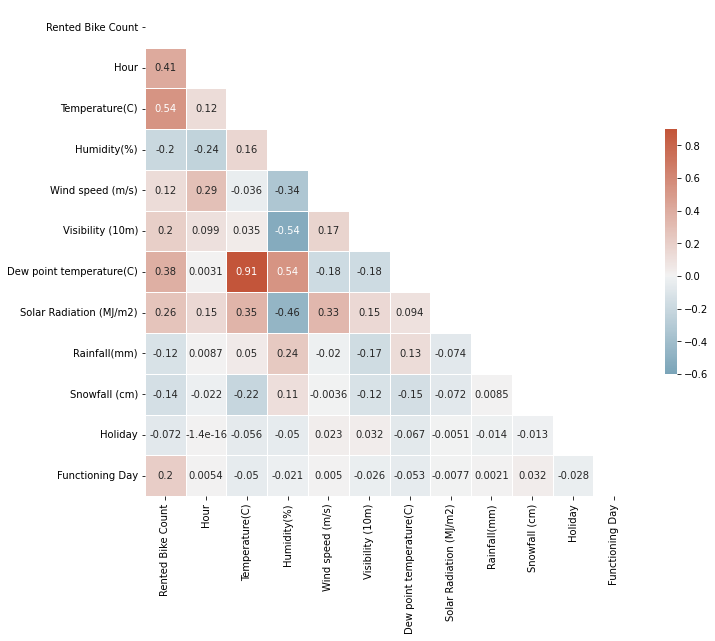

In [13]:
bikes_corr = bikes_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(bikes_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(bikes_corr, mask=mask, cmap=cmap, vmax=.9, vmin=-.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

In [14]:
frequency_table = pd.crosstab(bikes_df['Holiday'], bikes_df['Functioning Day'])
print(frequency_table)

Functioning Day  False  True
Holiday                     
False              271  8057
True                24   408


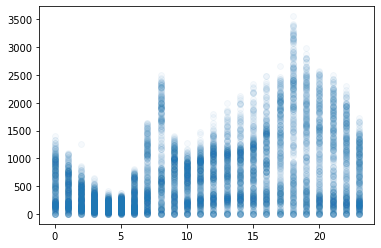

In [25]:
plt.scatter(data=bikes_df, x='Hour', y='Rented Bike Count', alpha=0.04)
plt.show()

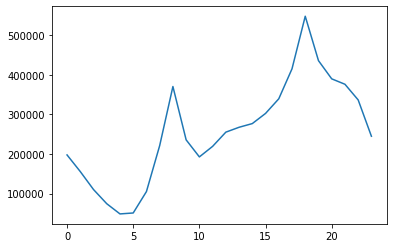

In [16]:
grouping = bikes_df[['Hour','Rented Bike Count']].groupby(['Hour']).sum().reset_index()
plt.plot(grouping['Hour'], grouping['Rented Bike Count'])
plt.show()

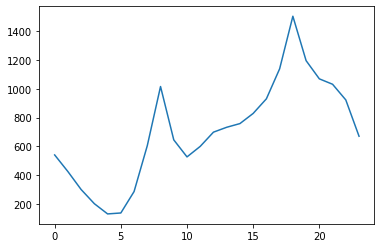

In [17]:
grouping = bikes_df[['Hour','Rented Bike Count']].groupby(['Hour']).mean().reset_index()
plt.plot(grouping['Hour'], grouping['Rented Bike Count'])
plt.show()

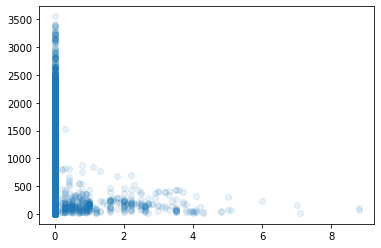

In [18]:
plt.scatter(data=bikes_df, x='Snowfall (cm)', y='Rented Bike Count', alpha = 0.1)
plt.show()

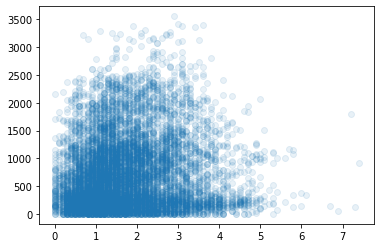

In [19]:
plt.scatter(data=bikes_df, x='Wind speed (m/s)', y='Rented Bike Count', alpha = 0.1)
plt.show()

In [20]:
# dropping the data when the service was not functioning at all, as it would affect the accuracy of the model
# bikes_df = bikes_df[bikes_df['Functioning Day'] == 'Yes']
# bikes_df = bikes_df.drop(columns=['Functioning Day'])
# print(bikes_df.shape)